# Intro

## Background Problem

Earth is currently the only planet on which humans and other creatures live. Sadly, human activities worsen the Earth's condition over time through global warming. Scientists have been monitoring earth's condition through images that captured from artificial satellites.

## Objective

To help scientist classify images that captured from satellite, I will create a deep learning model that can automate that process. Thus, scientists can focused on another tasks that harder or more important.

- There are 4 classes of images that will be used to train the model, such as: dessert, green area, water, and cloudy.
- In this project, I will consider that all image classes are equally important, thus the metric I choose is accuracy.
- To create a robust model for prediction, minimum accuracy that the model must produce is 90%.

Additional Note:
- I'm using 5% as score difference threshold to identify whether a model overfitting or not.
- This threshold applied for both accuracy and loss score

- Hence, this project aims to build a model with a difference in accuracy and loss scores of less than 5%.

# Import Libs

In [1]:
import os
from os.path import join as path_join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import DataFrameIterator

from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
# define dir const
IMG_DIR_PATH = "/kaggle/input/data"

In [3]:
# define image class list
img_classes = [dirname for dirname in os.listdir(IMG_DIR_PATH)]
img_classes

['cloudy', 'desert', 'green_area', 'water']

In [4]:
# define image examples to plot
img_examples_dict = {}

for img_class in img_classes:
    img_file_path = []

    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class))[:5]:
        img_file_path.append(
            path_join(IMG_DIR_PATH, img_class, img_file_name)
        )
        
    img_examples_dict[img_class] = img_file_path

In [5]:
img_examples_dict

{'cloudy': ['/kaggle/input/data/cloudy/train_17406.jpg',
  '/kaggle/input/data/cloudy/train_28684.jpg',
  '/kaggle/input/data/cloudy/train_33597.jpg',
  '/kaggle/input/data/cloudy/train_34079.jpg',
  '/kaggle/input/data/cloudy/train_30586.jpg'],
 'desert': ['/kaggle/input/data/desert/desert(14).jpg',
  '/kaggle/input/data/desert/desert(217).jpg',
  '/kaggle/input/data/desert/desert(204).jpg',
  '/kaggle/input/data/desert/desert(1030).jpg',
  '/kaggle/input/data/desert/desert(1080).jpg'],
 'green_area': ['/kaggle/input/data/green_area/Forest_2838.jpg',
  '/kaggle/input/data/green_area/Forest_205.jpg',
  '/kaggle/input/data/green_area/Forest_2038.jpg',
  '/kaggle/input/data/green_area/Forest_344.jpg',
  '/kaggle/input/data/green_area/Forest_2181.jpg'],
 'water': ['/kaggle/input/data/water/SeaLake_926.jpg',
  '/kaggle/input/data/water/SeaLake_907.jpg',
  '/kaggle/input/data/water/SeaLake_844.jpg',
  '/kaggle/input/data/water/SeaLake_830.jpg',
  '/kaggle/input/data/water/SeaLake_2215.jpg']

In [6]:
def read_img_rgb(img_file_path: str)->np.array:
    """
    Return image using cv2 using rgb channel as 3-dimensional array
    
        param:
            img_file_path (str): image file path to load
            
        return:
            3-dimensional array that represent r,g,b color channel
    """

    # openCV read image use bgr channel as default
    # but matplotlib use rgb channel
    # thus, I read the image using openCV first, then convert the color channel into rgb
    img = cv2.imread(img_file_path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
def show_subplot_img(
    ncols: int, 
    figsize: tuple, 
    imgs_dict: dict, 
    nrows: int=1,
    cmap: str="viridis",
    is_plot_rgb: bool=False
)->None:
    """
    PLot images in :imgs_dict using subplots
    
        params:
            ncols (int): number of columns for subplot
            figsize (tuple): figure size of the subplot (w, h) in inches
            imgs_dict (dict): 
            nrows (int): number of rows for subplot [default=1]
            cmap (str): default colormap used in matplotlib
            is_plot_rgb (bool): whether plot image on each color channel (r, g, b) separately or plot as whole (rgb) [default=False]
    
        return: None
    """
    
    if(not is_plot_rgb):
        for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
            
            for j, img in enumerate(img_dict):
                axs[j].imshow(img, cmap)
                axs[j].title.set_text(f"image {j+1}")
                
            fig.suptitle(img_class)
            
        plt.show()

    else:
        rgb_label=["r", "g", "b"]

        for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

            for j, img in enumerate(img_dict):
                axs[j].imshow(img, cmap)
                axs[j].title.set_text(f"channel {rgb_label[j]}")

            fig.suptitle(img_class)

        plt.show()

In [8]:
# I found out that images in dataset are having different size
# In this cell I do comprehensive analysis to find out 
# how many type of image sizes appear in the dataset

img_shape_64_64 = {}
img_shape_256_256 = {}
img_shape_else = []

for img_class in img_classes:
    img_64_64 = []
    img_256_256 = []
    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        img_read = read_img_rgb(path_join(IMG_DIR_PATH, img_class, img_file_name))
        if(img_read.shape==(64,64,3)):
            img_64_64.append(img_file_name)
        elif(img_read.shape==(256,256,3)):
            img_256_256.append(img_file_name)
        else:
            img_shape_else.append([img_read.shape, img_file_name])
    img_shape_64_64[img_class] = img_64_64
    img_shape_256_256[img_class] = img_256_256

print("image shape 64x64")
for k, v in img_shape_64_64.items():
    print(f"{k}: {len(v)}")

print("\nimage shape 256x256")
for k, v in img_shape_256_256.items():
    print(f"{k}: {len(v)}")

print("\nother shape: ", len(img_shape_else))

image shape 64x64
cloudy: 0
desert: 0
green_area: 1500
water: 1500

image shape 256x256
cloudy: 1500
desert: 1131
green_area: 0
water: 0

other shape:  0


In [9]:
# read 2 rgb images as examples

IMG_RGB_EXAMPLE1 = read_img_rgb(path_join(IMG_DIR_PATH, "green_area/Forest_344.jpg"))

IMG_RGB_EXAMPLE2 = read_img_rgb(path_join(IMG_DIR_PATH, "cloudy/train_33597.jpg"))

In [10]:
# print size of example images
print("ex img1 shape: ", IMG_RGB_EXAMPLE1.shape)
print("ex img2 shape: ", IMG_RGB_EXAMPLE2.shape)

ex img1 shape:  (64, 64, 3)
ex img2 shape:  (256, 256, 3)


- The in-depth analysis shows that the dataset contains 2 types of images in terms of size, such as 64x64x3 and 256x256x3.
- Since deep learning model requires images in the same size, thus I will use image size of 128x128x3 because it's a balanced choice that halves 256 and doubles 64

In [11]:
# defined image shapes with and without channel
IMG_SHAPE = (128, 128)
IMG_SHAPE_WITH_CHANNEL = (128, 128, 3)

## EDA

In [12]:
# read all images and store into dict
img_rgbs_dict={}
for k, img_file_paths in img_examples_dict.items():
    img_read = []
    
    for img_file_path in img_file_paths:
        img_read.append(read_img_rgb(img_file_path))
    img_rgbs_dict[k] = img_read

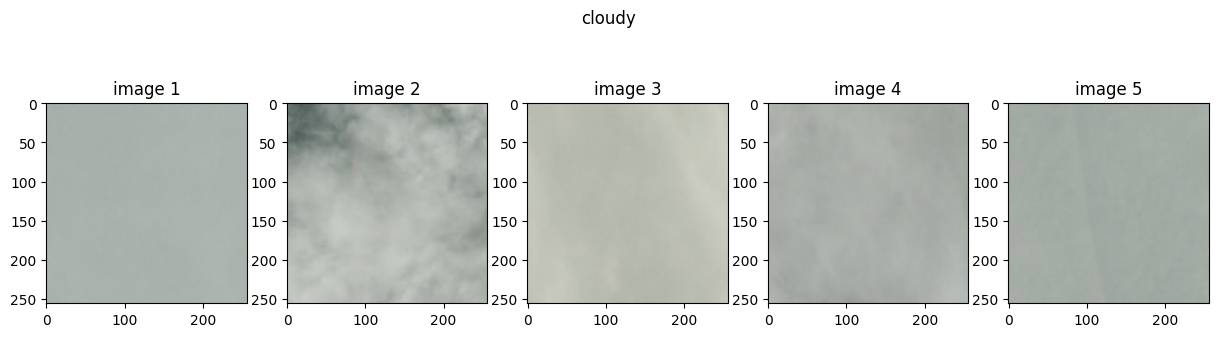

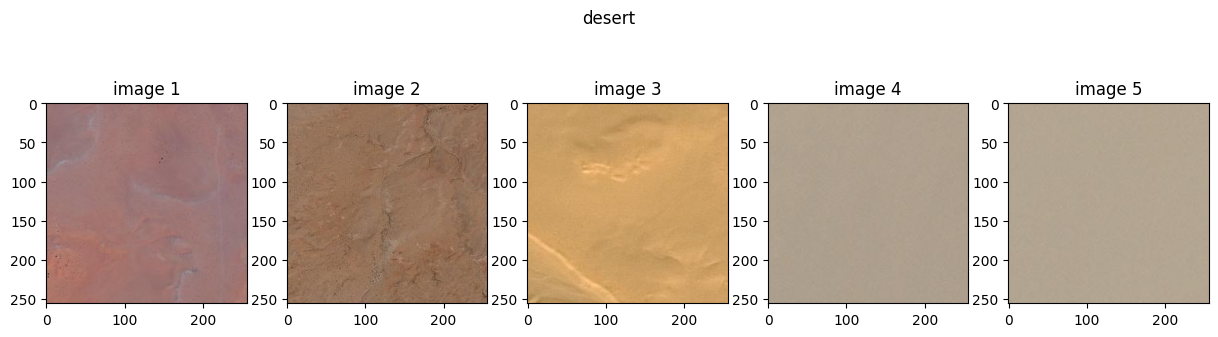

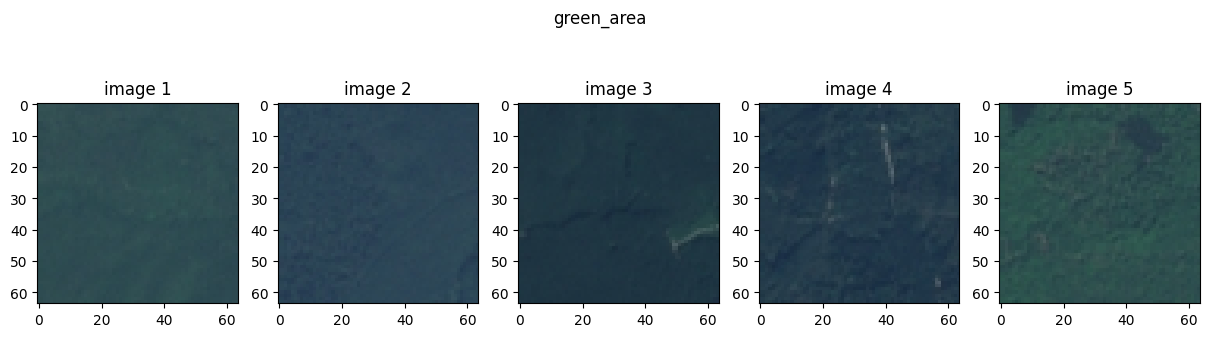

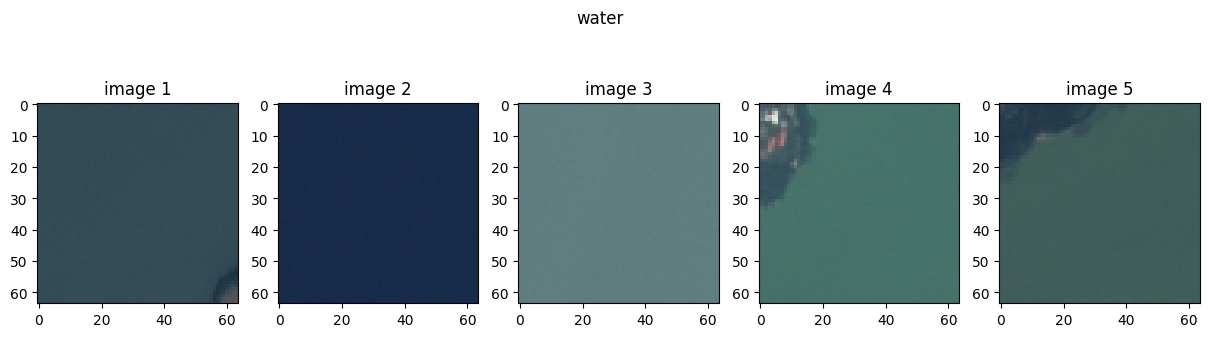

In [13]:
# plot 5 image for each class
show_subplot_img(5, (15, 4), img_rgbs_dict)

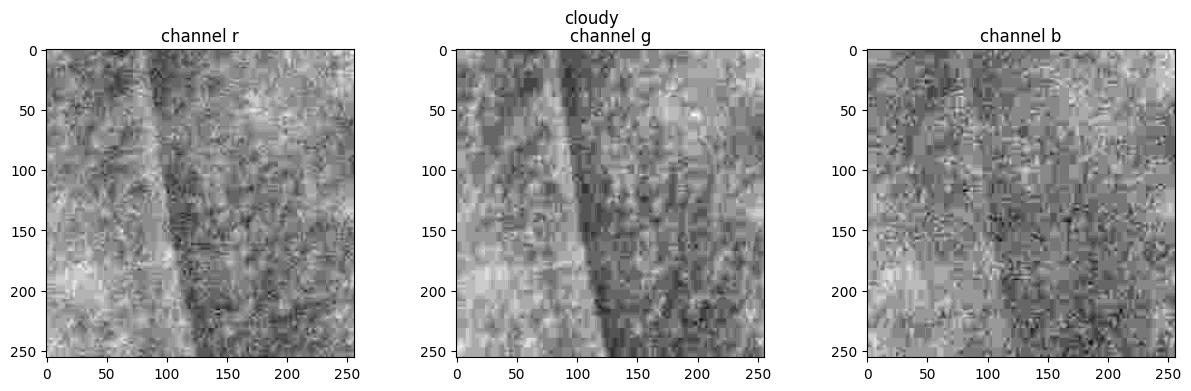

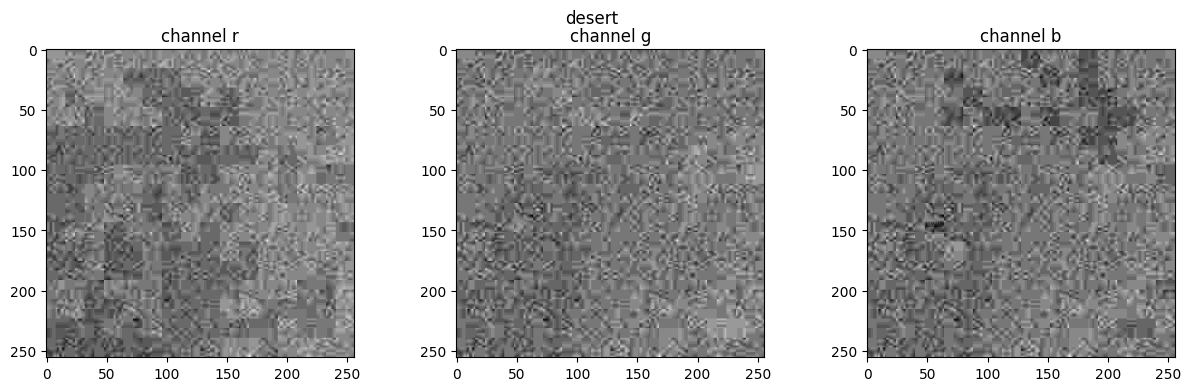

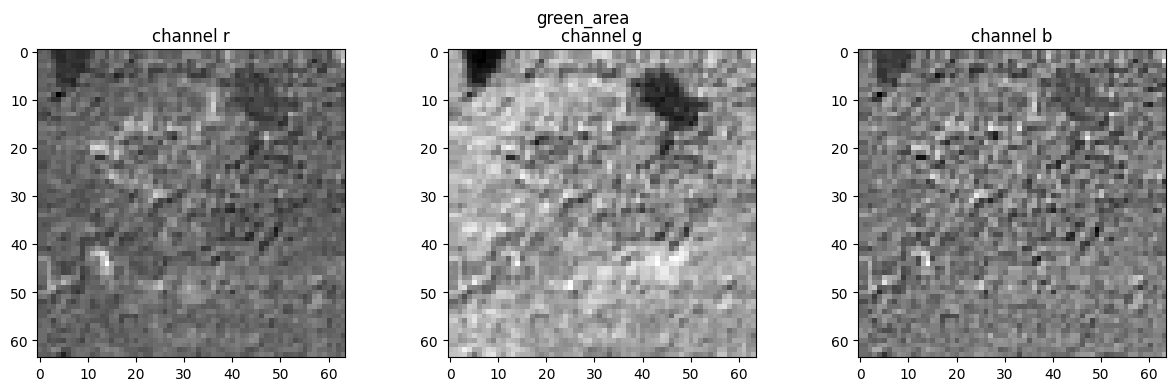

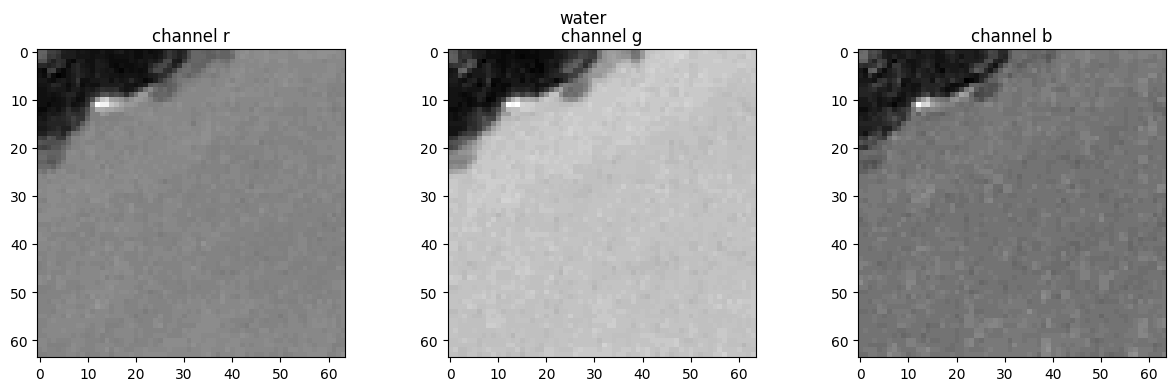

In [14]:
# plot rgb for each img class on 5th image
for img_class, img_rgbs in img_rgbs_dict.items():

    # split each color channel of an image
    r,g,b = cv2.split(img_rgbs[4])
    img_wrapper_dict = {img_class: [r,g,b]}
    
    show_subplot_img(3, (15, 4), img_wrapper_dict, cmap="gray", is_plot_rgb=True)

- The visualizations shown that charactheristics of images based on each color channel are simmilar.
- But, when it comes to colors, it's easier to differentiate these images
    - Cloudy area: gray
    - Dessert: somewhat brown
    - Green area: mixture of blue and green with contours that spread into all area
    - Water: mixture of blue and green that might contains objects

- Based on my analysis, these images can be distinguished by image's objects and colors. `Thus, I will use rbg image color to train the model`
- But, `I also will create a model that trained using grayscale color to prove my analysis`

# Feature Engineering

In this project, I will do some image augmentations to add variability on train and validation data, such as:
- Illumination or brightness
- Contrast

Hopefully these image augmentations will help the model to understand each class's characteristics better, thus increase the overall accuracy.

## Illuminate

In [15]:
# define matrix to adjust image's brightness
matrix_bright = np.ones(IMG_RGB_EXAMPLE2.shape, dtype="uint8") * 50

In [16]:
# brighten an image
img_rgb_brightened = cv2.add(
    IMG_RGB_EXAMPLE2,
    matrix_bright
)

# darken an image
img_rgb_darkened = cv2.subtract(
    IMG_RGB_EXAMPLE2, 
    matrix_bright
)

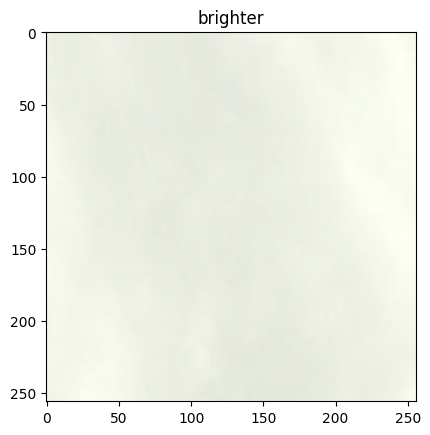

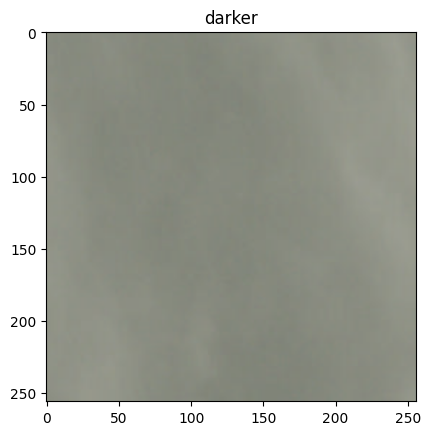

In [17]:
# plot adjusted brigthness image
plt.imshow(img_rgb_brightened)
plt.title("brighter")
plt.show()

plt.imshow(img_rgb_darkened)
plt.title("darker")
plt.show()

## Contrast

In [18]:
# define matrix for increasing and decreasing contrast
matrix_contrast_up = np.ones(IMG_RGB_EXAMPLE2.shape) * 1.6
matrix_contrast_down = np.ones(IMG_RGB_EXAMPLE2.shape) * 0.4

In [19]:
# adjust images' contrasts
img_rgb_cont_up   = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_up
    )
)

img_rgb_brightened_cont_up = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_brightened), 
        matrix_contrast_up)
    )

img_rgb_cont_down = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_down
    )
)

img_rgb_darkened_cont_down = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_darkened), 
        matrix_contrast_down
    )
)

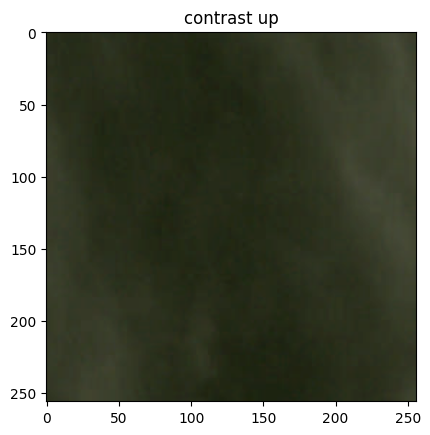

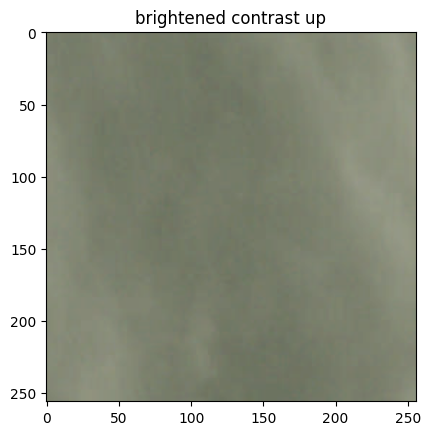

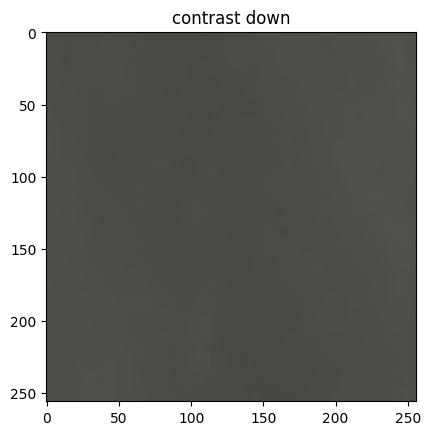

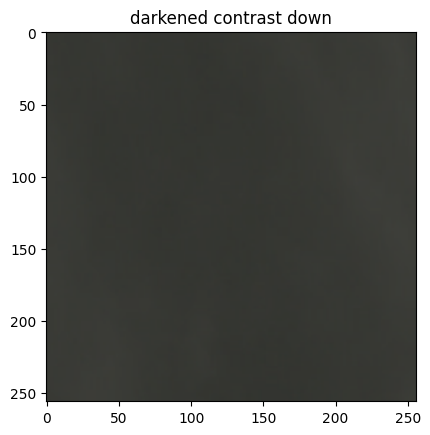

In [20]:
# plot adjusted contrast images
plt.imshow(img_rgb_cont_up)
plt.title("contrast up")
plt.show()

plt.imshow(img_rgb_brightened_cont_up)
plt.title("brightened contrast up")
plt.show()

plt.imshow(img_rgb_cont_down)
plt.title("contrast down")
plt.show()

plt.imshow(img_rgb_darkened_cont_down)
plt.title("darkened contrast down")
plt.show()

In [21]:
# provide list of labels and image paths to create dataframe
labels = [] 
paths = []

for img_class in img_classes:
    for file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        labels.append(img_class)
        paths.append(path_join(IMG_DIR_PATH, img_class, file_name))

In [22]:
print(labels[:5])
print(labels[-5:])

['cloudy', 'cloudy', 'cloudy', 'cloudy', 'cloudy']
['water', 'water', 'water', 'water', 'water']


In [23]:
print(paths[:5])
print(paths[-5:])

['/kaggle/input/data/cloudy/train_17406.jpg', '/kaggle/input/data/cloudy/train_28684.jpg', '/kaggle/input/data/cloudy/train_33597.jpg', '/kaggle/input/data/cloudy/train_34079.jpg', '/kaggle/input/data/cloudy/train_30586.jpg']
['/kaggle/input/data/water/SeaLake_682.jpg', '/kaggle/input/data/water/SeaLake_1614.jpg', '/kaggle/input/data/water/SeaLake_1184.jpg', '/kaggle/input/data/water/SeaLake_1427.jpg', '/kaggle/input/data/water/SeaLake_2146.jpg']


In [24]:
# create dataframe contains label and image path
img_df = pd.DataFrame(
    data={
        "label": labels,
        "path": paths
    }
)

img_df

label                                       path
0     cloudy  /kaggle/input/data/cloudy/train_17406.jpg
1     cloudy  /kaggle/input/data/cloudy/train_28684.jpg
2     cloudy  /kaggle/input/data/cloudy/train_33597.jpg
3     cloudy  /kaggle/input/data/cloudy/train_34079.jpg
4     cloudy  /kaggle/input/data/cloudy/train_30586.jpg
...      ...                                        ...
5626   water   /kaggle/input/data/water/SeaLake_682.jpg
5627   water  /kaggle/input/data/water/SeaLake_1614.jpg
5628   water  /kaggle/input/data/water/SeaLake_1184.jpg
5629   water  /kaggle/input/data/water/SeaLake_1427.jpg
5630   water  /kaggle/input/data/water/SeaLake_2146.jpg

[5631 rows x 2 columns]

In [25]:
def get_index_sample_without_replace(
    df: pd.DataFrame, 
    sample_size: int
):
    """
    Get :sample_size number of indexes without replacement for sample data from :df
    
        param:
            df (pd.DataFrame): data source that contains label and path of each image
            
        return:
            index of samples as list
    """
    
    return list(
        df.sample(
            n=sample_size,
            replace=False,
            random_state=9
        ).index
    )

## Data Splitting

In [26]:
# define dict to contains number of samples of ecach image class
# used for test set
test_sizes_dict = {}

for img_class in img_df["label"].unique():
    # sample 5%
    test_sizes_dict[img_class] = int(0.05 * img_df[img_df["label"]==img_class].shape[0])
    
test_sizes_dict

{'cloudy': 75, 'desert': 56, 'green_area': 75, 'water': 75}

In [27]:
# define list to contain index of images for the test set
test_data_idx = []
for img_class, sample_size in test_sizes_dict.items():
    test_data_idx+=get_index_sample_without_replace(
        img_df[img_df["label"]==img_class], 
        sample_size
    )

In [28]:
len(set(test_data_idx))

281

> All test data indexes are unique

In [29]:
# split dataset into 2: test & train-val
img_test_df = img_df.iloc[test_data_idx]
img_train_val_df = img_df.drop(index=test_data_idx)

In [30]:
img_train_val_df["label"].value_counts(normalize=True)

label
cloudy        0.266355
green_area    0.266355
water         0.266355
desert        0.200935
Name: proportion, dtype: float64

In [31]:
img_test_df["label"].value_counts(normalize=True)

label
cloudy        0.266904
green_area    0.266904
water         0.266904
desert        0.199288
Name: proportion, dtype: float64

In [32]:
# print shape, num of rows with missing and duplicated values
# on all image generators
for (label, df) in zip(
    ["img train-val", "img test"], 
    [img_train_val_df, img_test_df]
):
    print(label)
    print("shape: ", df.shape)
    print("number of rows with missing value: ", df.isna().sum().sum())
    print("number of rows with duplicated value: ", df.duplicated().sum(), end="\n\n")

img train-val
shape:  (5350, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0

img test
shape:  (281, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0



## Image Generator

In this step I will add more variances on images for training and validation. This step will make sure that the model will learn wider range of image's characteristics.
The augmentation process including:
- horizontal & vertical flip
- zoom range 1 to 1,5
- rescale 1/255 -> rescaling to decrease the image's pixels while still retaining the same information, this can make the training process faster
- batch processing -> improve training speed and generalizability

In [33]:
def create_img_generators(
    validation_split: float,
    rescale: float=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range: list=[0.5, 1], # 0.5 means zoom in 50%
)->tuple:
    """
    Create 2 image generators: (train and validation) and test
    
        params:
            validation_split (float): proportion for validation set
            rescale (float): fraction used for rescaling each pixel of an image [default=1./255]
            horizontal_flip (bool): whether apply horizontal flip to images [default=True]
            vertical_flip (bool): whether apply vertical flip to images [default=True]
            zoom_range (list): 
    """
    
    train_val_img_datagen = ImageDataGenerator(
        validation_split=validation_split,
        rescale=rescale,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        zoom_range=zoom_range
    )
    
    test_img_datagen = ImageDataGenerator(rescale=rescale)
    
    return train_val_img_datagen, test_img_datagen

In [34]:
def get_adjusted_contrast_img(img: object) -> object:
    """
    Get adjusted contrast of :img using range contrast value from 0.4 to 1.6
    
        param:
            img (object): the image that needs contrast adjustment
    
        return:
            image with new contrast (object)
    """
    return tf.image.random_contrast(
        img, 
        lower=0.4, 
        upper=1.6, 
        seed=9
    )

In [35]:
def generate_img_generators(
    train_val_img_datagen: ImageDataGenerator,
    test_img_datagen: ImageDataGenerator,
    color_mode: str,
    batch_size: int,
    img_train_val_df: pd.DataFrame=img_train_val_df,
    img_test_df: pd.DataFrame=img_test_df,
    target_size: tuple=IMG_SHAPE, # datagen only need height & width size
    class_mode: str="categorical",
    x_col: str="path",
    y_col: str="label",
    keep_aspect_ratio: bool=True,
    seed: int=9,
    preprocessing_function: object=get_adjusted_contrast_img
)->tuple:
    """
    Generate 3 image generators: train, validation, and test
    
        params:
            train_val_img_datagen (ImageDataGenerator): image generator for train and val set
            test_img_datagen (ImageDataGenerator): image generator for test set
            color_mode (str): color mode of the image, can be either 'rgb' or 'grayscale'
            batch_size (int): number of batch used per epoch
            img_train_val_df (pd.DataFrame): dataframe that contains train and validation image data [default=`img_train_val_df`]
            img_test_df (pd.DataFrame): dataframe that contains test image data [default=`img_test_df`]
            target_size (tuple): target size of images that will be used for training [default=`IMG_SHAPE`]
            class_mode (str): class mode used for training [default='categorical']
            x_col (str): column name used as feature for training [default='path']
            y_col (str): column name used as label for training [default='label']
            keep_aspect_ratio (bool): whether to keep the image's aspect ratio when resizing is applied [default=True]
            seed (int): generator's seed key [default=9]
            preprocessing_function (object): additional function to call for image augmentation
            
        return:
            img_train, img_val, img_test (tuple): generated image generator from dataframe for train, validation, and test respectively
    """
    
    if(color_mode not in ["grayscale", "rgb"]):
        raise ValueError("Color mode can only either grayscale or rgb")
    
    img_train = train_val_img_datagen.flow_from_dataframe(
        img_train_val_df,
        target_size=IMG_SHAPE,
        class_mode=class_mode,
        x_col=x_col,
        y_col=y_col,
        keep_aspect_ratio=keep_aspect_ratio,
        seed=seed,
        subset="training",
        shuffle=True,
        batch_size=batch_size,
        preprocessing_function=preprocessing_function,
        color_mode=color_mode
    )
    
    img_val = train_val_img_datagen.flow_from_dataframe(
        img_train_val_df,
        target_size=IMG_SHAPE,
        class_mode=class_mode,
        x_col=x_col,
        y_col=y_col,
        keep_aspect_ratio=keep_aspect_ratio,
        seed=seed,
        subset="validation",
        shuffle=True,
        batch_size=batch_size,
        preprocessing_function=preprocessing_function,
        color_mode=color_mode
    )
    
    img_test = train_val_img_datagen.flow_from_dataframe(
        img_test_df,
        target_size=IMG_SHAPE,
        class_mode=class_mode,
        x_col=x_col,
        y_col=y_col,
        keep_aspect_ratio=keep_aspect_ratio,
        seed=seed,
        shuffle=False,
        batch_size=batch_size,
        preprocessing_function=preprocessing_function,
        color_mode=color_mode
    )
    
    return img_train, img_val, img_test
    

In [36]:
# create image data generator for train-val images
# I will use 15% of images for validation
train_val_img_datagen, test_img_datagen = create_img_generators(validation_split=0.15)

### Gray Scale

In [37]:
img_train_gray, img_val_gray, img_test_gray = generate_img_generators(
    train_val_img_datagen,
    test_img_datagen,
    "grayscale",
    64
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


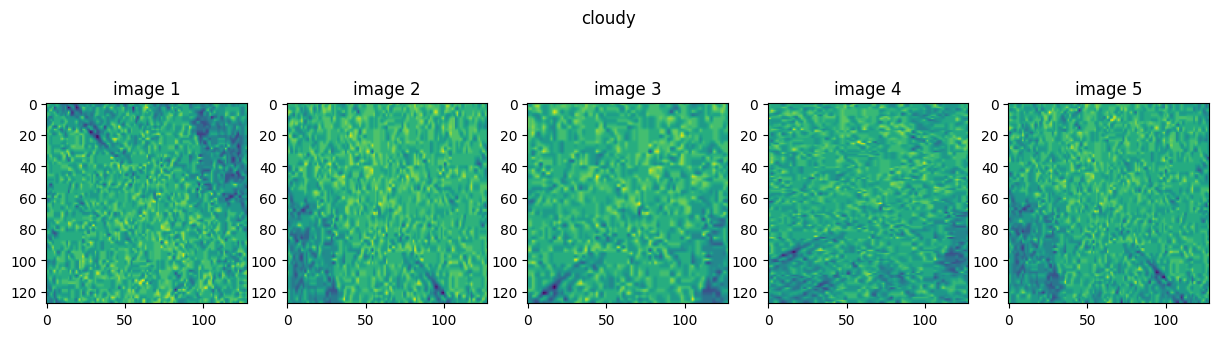

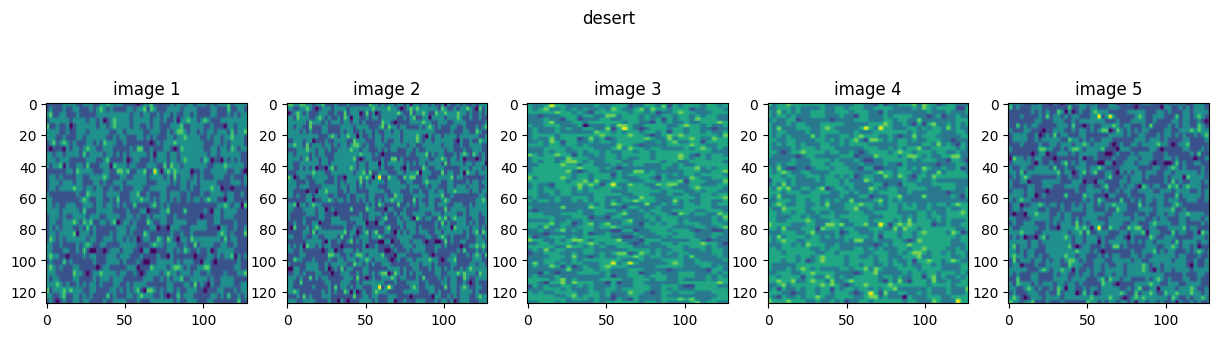

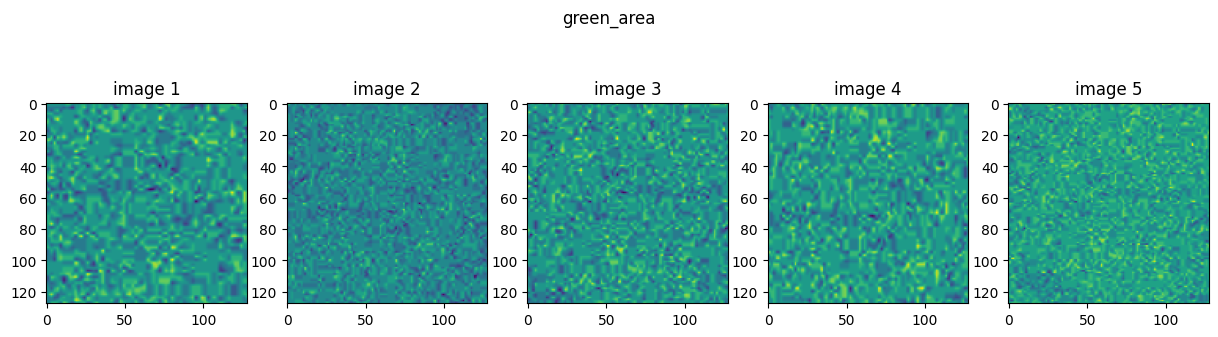

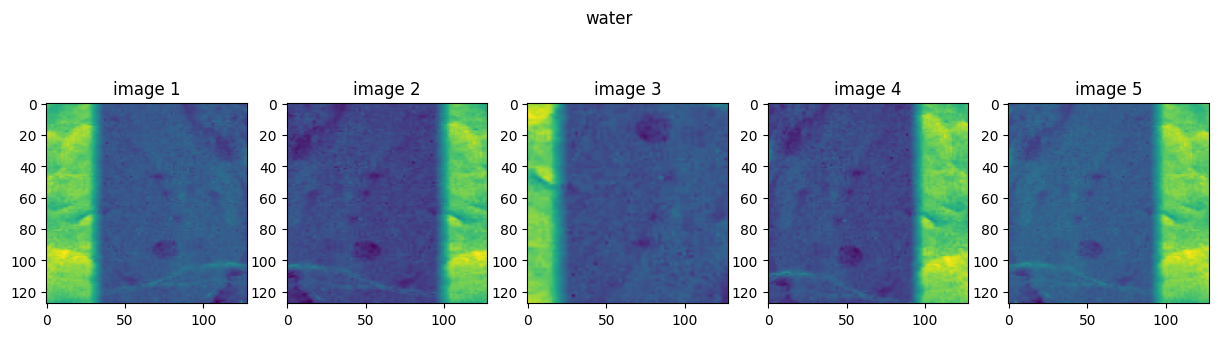

In [38]:
# plot some augmented grayscale images
img_gen_grayscales_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train_gray.class_indices):
    img_gen_grays = []
    for j in range(5):
        img_gen_grays.append(img_train_gray[0][0][img_pos])

    img_gen_grayscales_dict[batch_name] = img_gen_grays
    img_pos+=5
    
# plot 5 augmented grayscale images per class
show_subplot_img(5, (15, 4), img_gen_grayscales_dict)

### RGB

In [39]:
img_train_rgb, img_val_rgb, img_test_rgb = generate_img_generators(
    train_val_img_datagen,
    test_img_datagen,
    "rgb",
    64
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


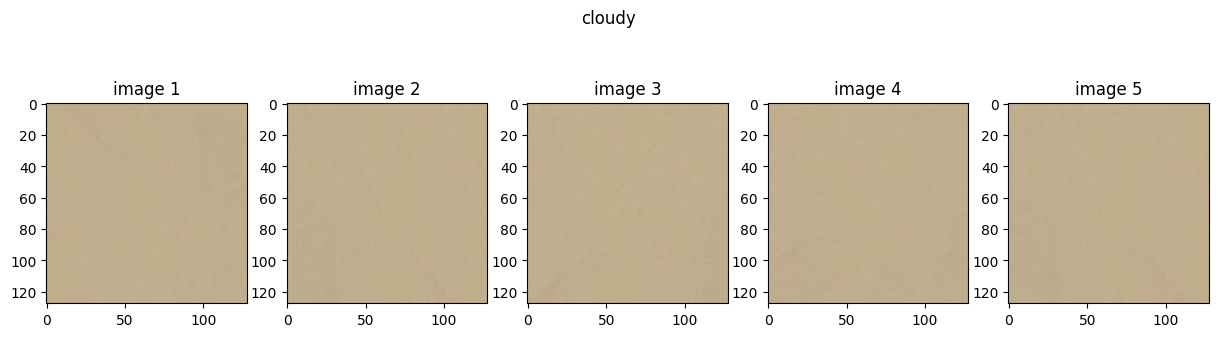

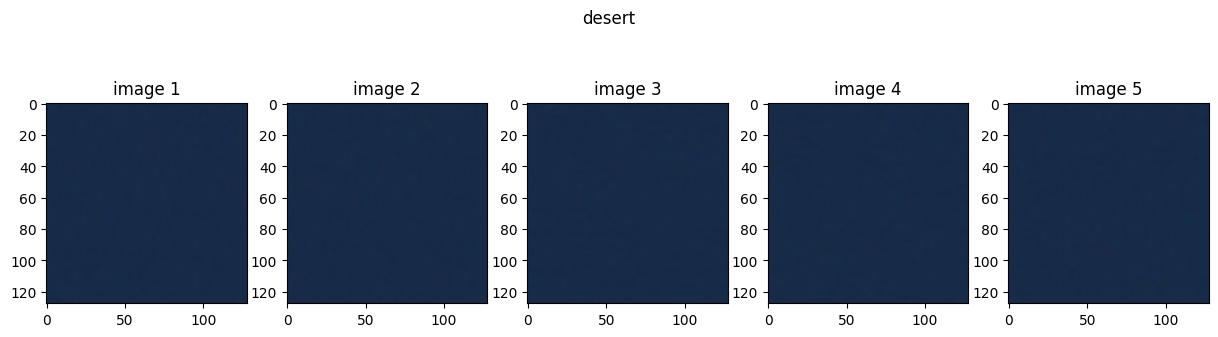

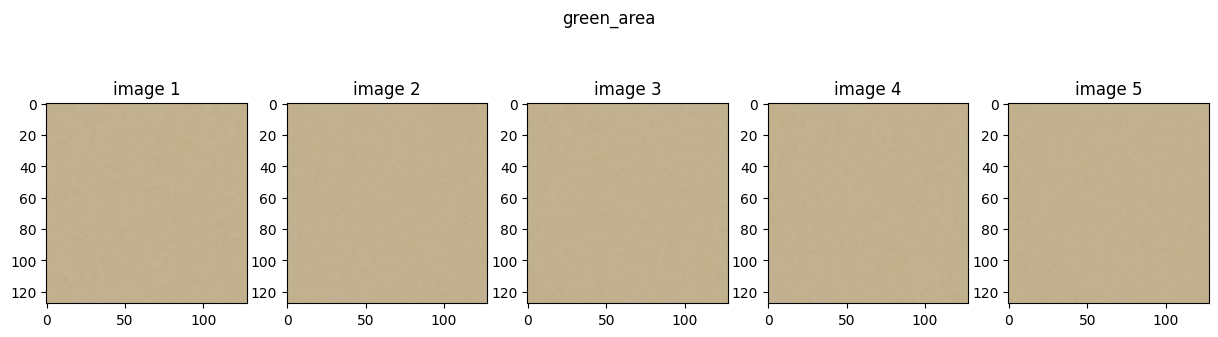

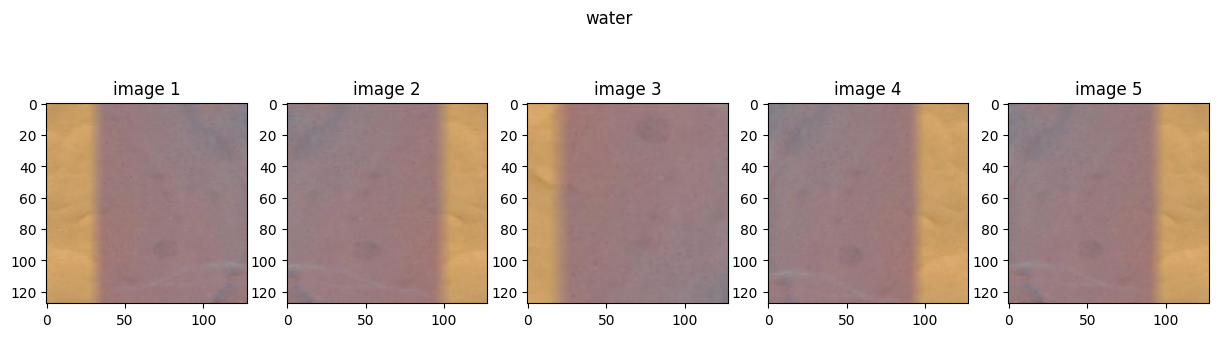

In [40]:
# plot some augmented rgb images
img_gen_rgbs_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train_rgb.class_indices):
    img_gen_rgbs = []
    for j in range(5):
        img_gen_rgbs.append(img_train_rgb[0][0][img_pos])

    img_gen_rgbs_dict[batch_name] = img_gen_rgbs
    img_pos+=5
    
# plot 5 augmented rgb images per class
show_subplot_img(5, (15, 4), img_gen_rgbs_dict)

> Number of images for training, validation, and test are 4,548; 802; and 281 respectively for both rgb and grayscale images

# Modelling

In [41]:
def get_model_history(
    model: object,
    loss_function: object,
    optimizer: object,
    metrics: list,
    train_data: DataFrameIterator,
    val_data: DataFrameIterator,
    epochs: int,
    callbacks: list=None
)->pd.DataFrame:
    """
    Get history of model training process as dataframe.

    This function process end-to-end training process in the following steps:
    1. compile
    2. fitting
    3. return the training history as dataframe
    
        params:
            model (object): model that hasn't been fitted
            loss_function (object): loss function used when compiling the model
            optimizer (object): optimezer function used when compiling the model
            metrics (list): list of evaluation metrics
            train_data (DataFrameIterator): data train from DataImageGenerator
            val_data (DataFrameIterator): data validation from DataImageGenerator
            epochs (int): number of epochs for model fitting process
            callbacks (list): list of callback functions to call in the model fitting process [default=None]

        return:
            trining history of the model (pd.DataFrame)
    """

    model.compile(
        loss=loss_function, 
        optimizer=optimizer, 
        metrics=metrics
    )

    history = model.fit(
        train_data, 
        epochs=epochs, 
        validation_data=val_data, 
        # print model's training progress
        verbose=1,
        callbacks=callbacks
    )

    return pd.DataFrame(history.history)

In [42]:
def plot_model_history(df: pd.DataFrame, model_name: str)->None:
    """
    Plot model training history to show accuracy and loss

        param:
            df (pd.DataFrame) -> data source that contains accuracy and loss on train and val sets
            model_name (str): the model's name for plot title

        return: None
    """

    # plot accuracy on train and val set
    df[["accuracy", "val_accuracy"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy on Train and Val set on {}".format(model_name))
    plt.show()
    
    # plot loss on train and val set
    df[["loss", "val_loss"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss on Train and Val set on {}".format(model_name))
    plt.show()

In [43]:
def print_model_evaluation(model: object, test_data: DataFrameIterator)->None:
    """
    Print :model evaluation on :test_data
    
        params:
            model (object): fitted model
            test_data(DataFrameIterator): image generator that contains images of test set
    
        return: None
    """
    pred_res = model.predict(test_data, verbose=False)
    pred_res = np.argmax(pred_res, axis=1)
    
    print("accuracy: {}".format(accuracy_score(test_data.classes, pred_res).round(2)))
    print("\nclassification report")
    print(classification_report(test_data.classes, pred_res, target_names=test_data.class_indices))

In [73]:
def get_early_stopping(
    patience: int=5,
    monitor: str="val_accuracy",
    mode: str="max",
    start_from_epoch: int=10,
    verbose: int=1,
)->EarlyStopping:
    """
    Return early stopping that can only be used for callback function in model training process.
    Early stopping will terminate model training process based on defined parameters
    
        params:
            patience (int): number of epochs with no improvement after which training will be stopped [default=5]
            monitor (str): quantity to be monitored [default='val_accuracy']
            mode (str): configure when early function called during trainig process [default='max']
                - 'max': stop when the quantity monitored has stopped increasing
            start_from_epoch (int): number of epochs to wait before starting to monitor improvement [default=10]
            verbose (int): whether to print a notification when early stopping executed
            
        return: `EarlyStopping`
    """
    
    return EarlyStopping(
            patience=patience,
            monitor='val_accuracy',
            mode="max",
            start_from_epoch=10,
            verbose=1
        )

## Model 1

### Training

For the first model, I will try this configurations:
- layers:
    - convolution2d
        - filter: 128
        - activation: relu
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
    - avg pooling 2d
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - padding: same -> mantaining pixel on each image's edges, since some images are having important object for differentiate image's characteristics on some edges
    - convolution 2d
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - filter: 258
        - activation: relu
    - flatten -> convert multidimensional data into one dimensional data, so it can be feeded to dense layer
    - dense
        - activation: relu
        - units: 512
    - dense (output)
        - activation: softmax -> for multi class classification
        - units: 4 -> to identify 4 classes
- optimizer: adam
- metrics: accuracy -> stated in objective
- epochs: 20 -> try high epoch to get the best result, since I implemented early stopping
- callback: early stopping
    - patience: 5 -> high patience so that the model won't miss global optima
    - monitor: val accuracy
    - mode: max -> stop the training process if the accuracy on validation data hasn't increasing by 10 tries
- loss function: categorical crossentrophy -> for multi class classification

- The value of filter and units on convolution and dense layer are increasing to get better result on accuracy [reference](https://www.quora.com/How-does-increasing-filter-size-improve-the-accuracy-of-a-convolutional-neural-network-CNN#:~:text=Increasing%20the%20filter%20size%20in,make%20predictions%20about%20the%20data.)

### Gray Scale

In [45]:
model1_gray = Sequential([
    Input((128, 128, 1)),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1_gray")

model1_gray.summary()

Model: "model1_gray"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 128)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,688,964 (128.51 MB)

 Trainable params: 33,688,964 (128.51 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
%%time
history1_gray = get_model_history(
    model1_gray,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.001),
    ["accuracy"],
    img_train_gray,
    img_val_gray,
    20,
    callbacks=[get_early_stopping()]
)

history1_gray

Epoch 1/20


I0000 00:00:1727946736.345650    2862 service.cc:145] XLA service 0x7ba5080066e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727946736.345746    2862 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/72 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.2552 - loss: 1.8014

I0000 00:00:1727946738.202199    2862 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.4171 - loss: 1.1920 - val_accuracy: 0.0274 - val_loss: 1.5425
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step - accuracy: 0.6539 - loss: 0.6768 - val_accuracy: 0.0000e+00 - val_loss: 2.2136
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.6767 - loss: 0.6662 - val_accuracy: 0.4401 - val_loss: 0.7577
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.6797 - loss: 0.6369 - val_accuracy: 0.0362 - val_loss: 1.0898
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.6914 - loss: 0.6452 - val_accuracy: 0.0387 - val_loss: 1.3512
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.6883 - loss: 0.6299 - val_accuracy: 0.1696 - val_loss: 0.9415
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 175ms/step - accuracy: 0.6989 - loss: 0.6247 - val_accuracy: 0.0262 - val_loss: 1.0820
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.6851 - loss: 0.6351 - val_accuracy: 0

accuracy      loss  val_accuracy  val_loss
0   0.527924  0.921337      0.027431  1.542504
1   0.662709  0.669352      0.000000  2.213649
2   0.671064  0.657767      0.440150  0.757716
3   0.680079  0.636570      0.036160  1.089783
4   0.692392  0.634045      0.038653  1.351184
5   0.678320  0.646708      0.169576  0.941452
6   0.697230  0.625644      0.026185  1.082021
7   0.687335  0.643439      0.036160  1.069067
8   0.688215  0.634093      0.041147  1.023076
9   0.686675  0.633604      0.006234  1.169835
10  0.702067  0.620320      0.034913  1.074503
11  0.696350  0.616891      0.097257  1.078821
12  0.697669  0.610701      0.097257  1.363906
13  0.695690  0.618684      0.279302  0.968954
14  0.705145  0.616713      0.052369  1.272487
15  0.683597  0.618044      0.066085  1.000440
16  0.701847  0.611146      0.013716  1.439165
17  0.693712  0.622226      0.038653  1.132501
18  0.690413  0.631774      0.004988  1.545834

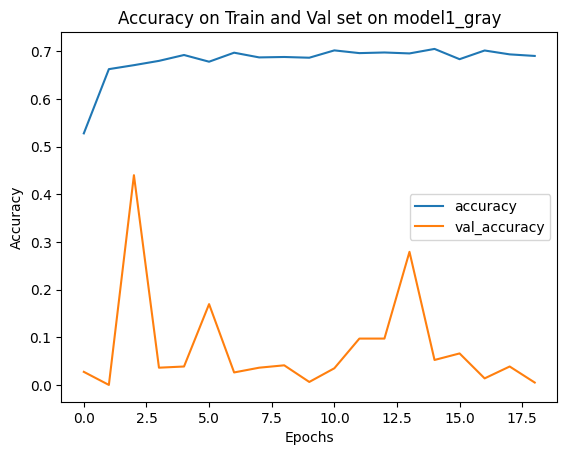

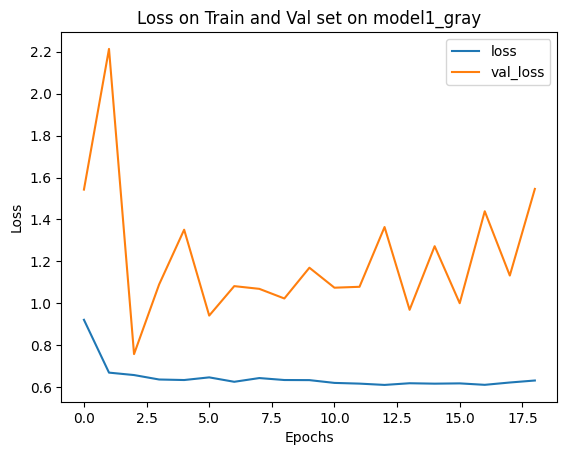

In [47]:
plot_model_history(history1_gray, model1_gray.name)

- The model trained using grayscaled images has overfitting problem
- This model were able to learn pretty well on training set, but its performance on validation set is much worse

#### Evaluation

In [48]:
print_model_evaluation(model1_gray, img_test_gray)

accuracy: 0.61

classification report
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00        75
      desert       0.45      0.98      0.62        56
  green_area       0.70      0.93      0.80        75
       water       0.78      0.61      0.69        75

    accuracy                           0.61       281
   macro avg       0.48      0.63      0.53       281
weighted avg       0.48      0.61      0.52       281



- This model only able to generate 61% accuracy, which means this model is not reliable to be used for classifying images.

### RGB

In [49]:
model1 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1")

model1.summary()

Model: "model1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
%%time
history_model1 = get_model_history(
    model1,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.001),
    ["accuracy"],
    img_train_rgb,
    img_val_rgb,
    20,
   callbacks=[get_early_stopping()]
)

history_model1

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 345ms/step - accuracy: 0.6029 - loss: 1.1570 - val_accuracy: 0.8491 - val_loss: 0.4402
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - accuracy: 0.8121 - loss: 0.4074 - val_accuracy: 0.6147 - val_loss: 0.8968
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 315ms/step - accuracy: 0.8606 - loss: 0.3268 - val_accuracy: 0.9352 - val_loss: 0.1290
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.8654 - loss: 0.3301 - val_accuracy: 0.7830 - val_loss: 0.6332
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.8711 - loss: 0.3339 - val_accuracy: 0.8628 - val_loss: 0.3975
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.8912 - loss: 0.2741 - val_accuracy: 0.7382 - val_loss: 0.7590
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step - accuracy: 0.8839 - loss: 0.2915 - val_accuracy: 0.9451 - val_loss: 0.1041
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.8309 - loss: 0.3701 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.722296  0.687754      0.849127  0.440247
1   0.831574  0.385801      0.614713  0.896796
2   0.868074  0.321350      0.935162  0.128985
3   0.868953  0.314350      0.783042  0.633190
4   0.884785  0.304363      0.862843  0.397481
5   0.881486  0.290591      0.738155  0.758961
6   0.883026  0.292585      0.945137  0.104080
7   0.848945  0.345290      0.862843  0.388787
8   0.870053  0.310739      0.947631  0.143674
9   0.888962  0.271060      0.897756  0.355330
10  0.891821  0.264625      0.923940  0.226788
11  0.895119  0.271834      0.865337  0.444024
12  0.835532  0.414099      0.897756  0.254593
13  0.898857  0.257143      0.906484  0.279960
14  0.899516  0.251408      0.885287  0.366488
15  0.896218  0.252244      0.861596  0.376372

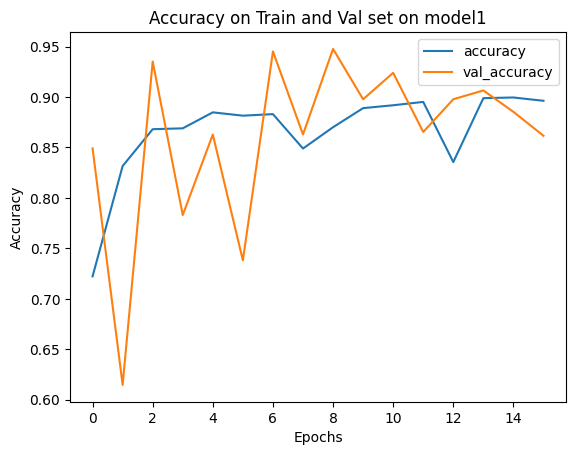

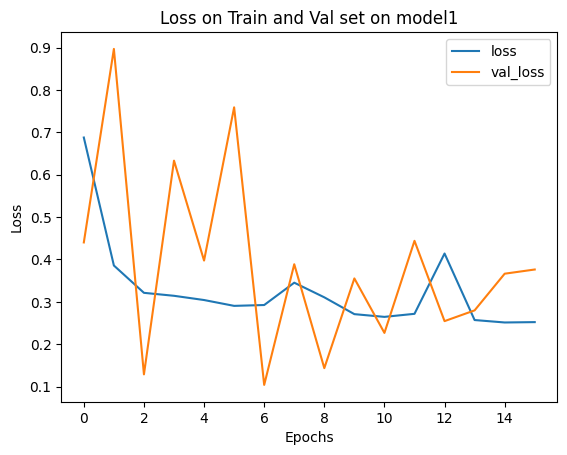

In [51]:
plot_model_history(history_model1, model1.name)

- This model able to generate accuracy on train and validation set by 90% and 86% respectively
- In addition, the error scores on train and validation sets are 25% and 38%
- Therefore, this model is overfitted


- This model also got volatiled evaluations for both validation accuracy and loss.
- This [reference](https://stackoverflow.com/questions/61287322/validation-loss-sometimes-spiking) asserted that **small number of validation data could cause volatility on training and validation set.**
- Since there's only 802 validation data for 4 classes, that statement might be the case.

<u>Concern:</u>
- Although the model's performance on accuracy scores are decent, it's actually overfitted.


- The number of validation set is pretty small.
- This could led into biased result. Since there's only small amount of variance on validation set, the model might remember the pattern in validation set.
- Therefore, I will increase number of validation set in hyperparameter tuning 1.

#### Evaluation

In [52]:
print_model_evaluation(model1, img_test_rgb)

accuracy: 0.91

classification report
              precision    recall  f1-score   support

      cloudy       0.98      0.81      0.89        75
      desert       0.93      0.98      0.96        56
  green_area       0.95      0.92      0.93        75
       water       0.83      0.96      0.89        75

    accuracy                           0.91       281
   macro avg       0.92      0.92      0.92       281
weighted avg       0.92      0.91      0.91       281



- This model was able to achieve an exceptional 94% accuracy by simply changing the training images from grayscale to RGB.

## Hyperparameter Tuning 1

In this section, I will increase the proportion of validation set from 15% to 20%

In [53]:
train_val_img_datagen_tuned1, test_img_datagen_tuned1 = create_img_generators(validation_split=0.2)

In [54]:
img_train_rgb_tuned1, img_val_rgb_tuned1, img_test_rgb_tuned1 = generate_img_generators(
    train_val_img_datagen_tuned1,
    test_img_datagen_tuned1,
    "rgb",
    64
)

Found 4280 validated image filenames belonging to 4 classes.
Found 1070 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


### Training

In [55]:
model_tuned1 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu",
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned1")

model_tuned1.summary()

Model: "model_tuned1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
%%time
history_model_tuned1 = get_model_history(
    model_tuned1,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned1,
    img_val_rgb_tuned1,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned1

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 28s 358ms/step - accuracy: 0.5659 - loss: 1.2771 - val_accuracy: 0.7327 - val_loss: 0.8356
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 342ms/step - accuracy: 0.8281 - loss: 0.4140 - val_accuracy: 0.8383 - val_loss: 0.5180
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 335ms/step - accuracy: 0.8521 - loss: 0.3693 - val_accuracy: 0.8636 - val_loss: 0.4482
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 337ms/step - accuracy: 0.8604 - loss: 0.3447 - val_accuracy: 0.8963 - val_loss: 0.2421
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 339ms/step - accuracy: 0.8612 - loss: 0.3374 - val_accuracy: 0.8879 - val_loss: 0.3053
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 333ms/step - accuracy: 0.8584 - loss: 0.3501 - val_accuracy: 0.5355 - val_loss: 1.3207
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step - accuracy: 0.8523 - loss: 0.3454 - val_accuracy: 0.7953 - val_loss: 0.6770
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 330ms/step - accuracy: 0.8755 - loss: 0.3183 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.700234  0.734420      0.732710  0.835616
1   0.827570  0.405192      0.838318  0.517956
2   0.848598  0.375106      0.863551  0.448211
3   0.857243  0.348929      0.896262  0.242116
4   0.855607  0.342523      0.887850  0.305311
5   0.859112  0.340506      0.535514  1.320729
6   0.862617  0.335395      0.795327  0.676953
7   0.876402  0.306703      0.733645  0.828620
8   0.876869  0.298590      0.548598  1.414032
9   0.870794  0.313156      0.894393  0.285205
10  0.884813  0.289975      0.901869  0.223959
11  0.888084  0.277307      0.814953  0.616289
12  0.889019  0.262712      0.872897  0.367330
13  0.896495  0.258492      0.884112  0.271909
14  0.893224  0.255897      0.844860  0.481056
15  0.900234  0.243238      0.849533  0.478659

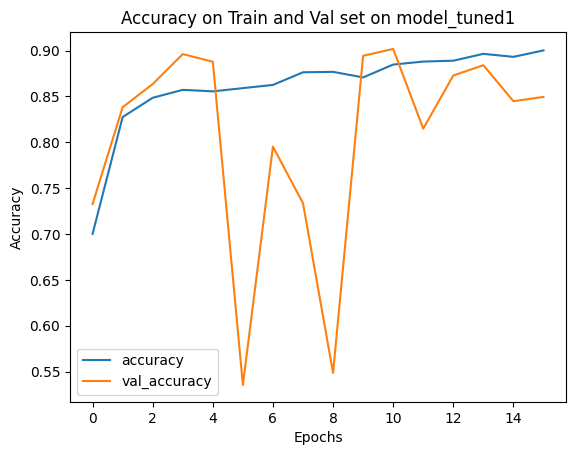

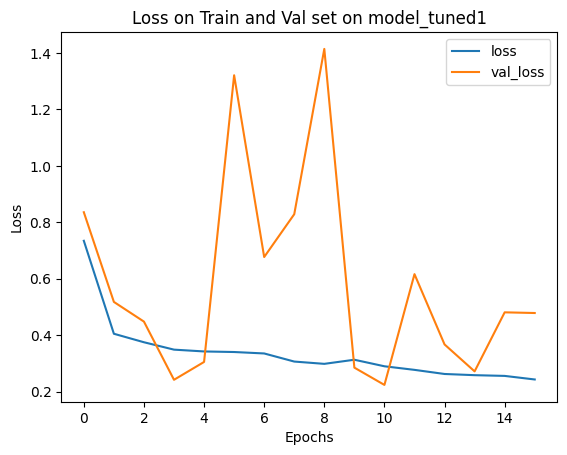

In [57]:
plot_model_history(history_model_tuned1, model_tuned1.name)

- The tuned model was able to generate 90% and 85% accuracy on train and validation sets respectively.
- But the error on train and validation are 24% and 48% respectively.
- Thus, this model is overfitted to train set

### Evaluation

In [58]:
print_model_evaluation(model_tuned1, img_test_rgb_tuned1)

accuracy: 0.94

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.92      0.95        75
      desert       0.90      0.98      0.94        56
  green_area       0.91      0.97      0.94        75
       water       0.97      0.91      0.94        75

    accuracy                           0.94       281
   macro avg       0.94      0.95      0.94       281
weighted avg       0.95      0.94      0.94       281



- This model performed worse than model 1 on train and validation sets


- Volatilities on validation accuracy and loss kind are somewhat reduced a little
- But, the problem remained persist.
- In conclusion, increasing number of validation data does reduced the volatility, but not significant.

## Hyperparameter Tuning 2

In this part, I will increase the batch size from 64 to 128 using tuned image generator

In [74]:
img_train_rgb_tuned2, img_val_rgb_tuned2, img_test_rgb_tuned2 = generate_img_generators(
    train_val_img_datagen_tuned1,
    test_img_datagen_tuned1,
    "rgb",
    128
)

Found 4280 validated image filenames belonging to 4 classes.
Found 1070 validated image filenames belonging to 4 classes.
Found 281 validated image filenames belonging to 4 classes.


In [75]:
model_tuned2 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu",
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned2")

model_tuned2.summary()

Model: "model_tuned2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
%%time
history_model_tuned2 = get_model_history(
    model_tuned2,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned2

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 669ms/step - accuracy: 0.5599 - loss: 0.9267 - val_accuracy: 0.7785 - val_loss: 0.6784
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 594ms/step - accuracy: 0.8089 - loss: 0.4752 - val_accuracy: 0.8467 - val_loss: 0.4921
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 586ms/step - accuracy: 0.8113 - loss: 0.4412 - val_accuracy: 0.9000 - val_loss: 0.2645
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 613ms/step - accuracy: 0.8609 - loss: 0.3851 - val_accuracy: 0.5972 - val_loss: 1.0341
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 589ms/step - accuracy: 0.8619 - loss: 0.3669 - val_accuracy: 0.8869 - val_loss: 0.3159
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 620ms/step - accuracy: 0.8550 - loss: 0.3584 - val_accuracy: 0.8738 - val_loss: 0.3410
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 616ms/step - accuracy: 0.8687 - loss: 0.3278 - val_accuracy: 0.8542 - val_loss: 0.4169
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 602ms/step - accuracy: 0.8738 - loss: 0.3178 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.672430  0.716820      0.778505  0.678381
1   0.819860  0.469617      0.846729  0.492119
2   0.825234  0.424013      0.900000  0.264549
3   0.864720  0.372123      0.597196  1.034132
4   0.850000  0.373272      0.886916  0.315912
5   0.860280  0.346247      0.873832  0.341045
6   0.873365  0.317922      0.854206  0.416851
7   0.878037  0.308121      0.788785  0.641564
8   0.883178  0.293077      0.843925  0.439617
9   0.885047  0.281718      0.835514  0.512842
10  0.884112  0.281799      0.706542  0.888574
11  0.886682  0.277587      0.878505  0.328032
12  0.891355  0.261659      0.890654  0.300977
13  0.889486  0.263196      0.830841  0.458480
14  0.894393  0.266621      0.842056  0.455935
15  0.899766  0.249877      0.840187  0.459832
16  0.897664  0.253009      0.775701  0.652013
17  0.901168  0.258401      0.867290  0.376106

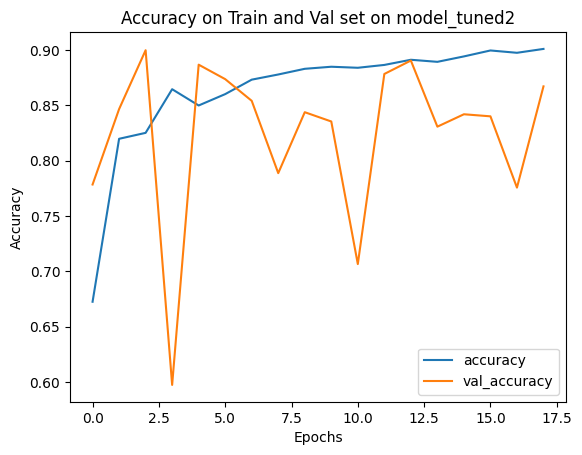

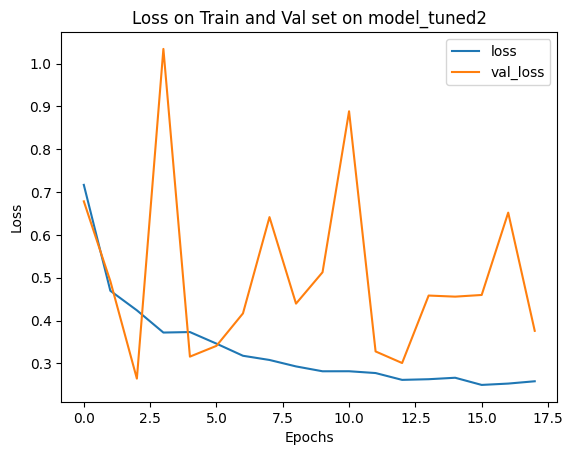

In [78]:
plot_model_history(history_model_tuned2, model_tuned2.name)

In [83]:
history_model_tuned1.iloc[-1]

accuracy        0.900234
loss            0.243238
val_accuracy    0.849533
val_loss        0.478659
Name: 15, dtype: float64

In [84]:
history_model_tuned2.iloc[-1]

accuracy        0.901168
loss            0.258401
val_accuracy    0.867290
val_loss        0.376106
Name: 17, dtype: float64

- This model performed better than hyper parameter tuned 1 model.
- Increasing the batch size to 128, vall loss reduced by 10%.
- This model has smaller difference of training and validation loss, but it still overfitted

### Evaluation

In [77]:
print_model_evaluation(model_tuned2, img_test_rgb_tuned2)

accuracy: 0.94

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.91      0.94        75
      desert       0.90      0.98      0.94        56
  green_area       0.91      0.97      0.94        75
       water       0.96      0.91      0.93        75

    accuracy                           0.94       281
   macro avg       0.94      0.94      0.94       281
weighted avg       0.94      0.94      0.94       281



- Because this model is able to reduce the loss score difference, **I consider it an improvement over Model 1**

- To further improve this model, I will add a dropout layer to address the overfitting problem.

## Hyperparameter Tuning 3

> add dropout layer 40%

[ref](https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network) stated that dropout can applied in various ways:
- after convolution layer: add small dropout layer (0.1<= drop out rate <=0.2)
- after each fully connected layer (dense) before output, initially p=0.5 was commonly used.

Considerations:

>In the original paper that proposed dropout layers, by Hinton (2012), dropout (with p=0.5) was used on each of the fully connected (dense) layers before the output; it was not used on the convolutional layers. This became the most commonly used configuration.

>More recent research has shown some value in applying dropout also to convolutional layers, although at much lower levels: p=0.1 or 0.2. Dropout was used after the activation function of each convolutional layer: CONV->RELU->DROP.

========================================================================

>The original paper proposed dropout layers that were used on each of the fully connected (dense) layers before the output; it was not used on the convolutional layers.

>We must not use dropout layer after convolutional layer as we slide the filter over the width and height of the input image we produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. So as dropout layer neutralizes (makes it zero) random neurons there are chances of loosing very important feature in an image in our training process.

In [85]:
model_tuned3 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dropout(
        rate=0.5,
        seed=9
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned3")

model_tuned3.summary()

Model: "model_tuned3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
%%time
history_model_tuned3 = get_model_history(
    model_tuned3,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned3

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 696ms/step - accuracy: 0.5034 - loss: 0.9810 - val_accuracy: 0.4981 - val_loss: 0.9780
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 598ms/step - accuracy: 0.6959 - loss: 0.5417 - val_accuracy: 0.7907 - val_loss: 0.6578
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 633ms/step - accuracy: 0.7864 - loss: 0.4786 - val_accuracy: 0.6206 - val_loss: 0.8851
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 600ms/step - accuracy: 0.8409 - loss: 0.4009 - val_accuracy: 0.8729 - val_loss: 0.3912
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step - accuracy: 0.8624 - loss: 0.3664 - val_accuracy: 0.8505 - val_loss: 0.4702
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 618ms/step - accuracy: 0.8546 - loss: 0.3631 - val_accuracy: 0.8280 - val_loss: 0.5672
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 602ms/step - accuracy: 0.8662 - loss: 0.3278 - val_accuracy: 0.8776 - val_loss: 0.3588
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - accuracy: 0.8720 - loss: 0.3164 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.589953  0.772118      0.498131  0.977992
1   0.717290  0.531877      0.790654  0.657828
2   0.803271  0.457333      0.620561  0.885096
3   0.835280  0.400826      0.872897  0.391215
4   0.859579  0.359447      0.850467  0.470218
5   0.855140  0.352155      0.828037  0.567227
6   0.865187  0.329418      0.877570  0.358793
7   0.874065  0.317913      0.871963  0.382442
8   0.875234  0.318258      0.858878  0.420995
9   0.870561  0.312418      0.783178  0.665995
10  0.877103  0.297427      0.851402  0.438918
11  0.882710  0.290811      0.844860  0.447555
12  0.881776  0.287593      0.846729  0.449043
13  0.891122  0.274711      0.842056  0.490328
14  0.889486  0.267935      0.844860  0.477491
15  0.884346  0.273550      0.860748  0.411142
16  0.891122  0.258748      0.901869  0.307466
17  0.890187  0.262324      0.836449  0.485746
18  0.901402  0.251307      0.807477  0.647875
19  0.896495  0.256573      0.852336  0.456973

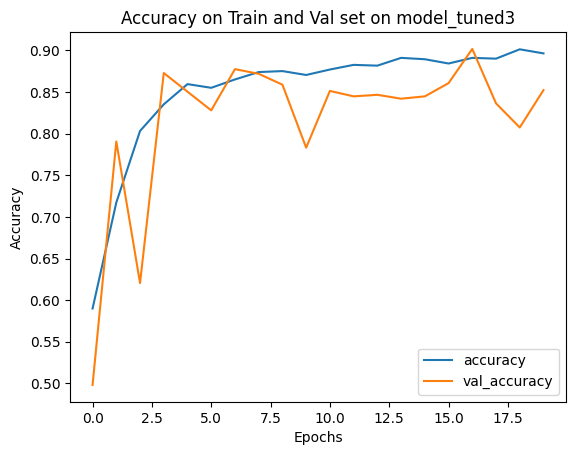

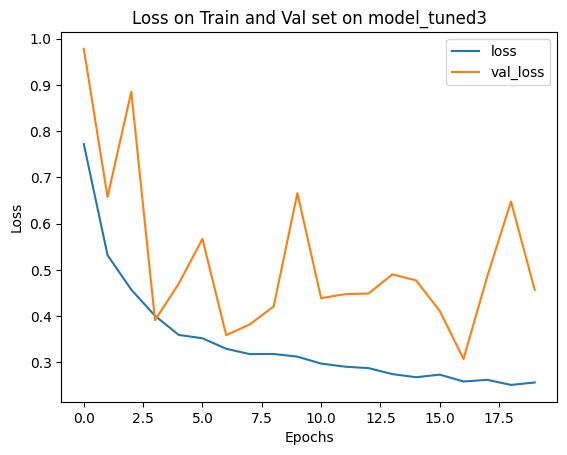

In [87]:
plot_model_history(history_model_tuned3, model_tuned3.name)

In [93]:
history_model_tuned2.iloc[-1]

accuracy        0.901168
loss            0.258401
val_accuracy    0.867290
val_loss        0.376106
Name: 17, dtype: float64

In [94]:
history_model_tuned3.iloc[-1]

accuracy        0.896495
loss            0.256573
val_accuracy    0.852336
val_loss        0.456973
Name: 19, dtype: float64

- Surprisingly, **adding a dropout layer failed to address the overfitting problem.** In fact, it made the validation loss worse.

### Evaluation

In [89]:
print_model_evaluation(model_tuned3, img_test_rgb_tuned2)

accuracy: 0.93

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.88      0.93        75
      desert       0.93      0.98      0.96        56
  green_area       0.95      0.93      0.94        75
       water       0.88      0.95      0.91        75

    accuracy                           0.93       281
   macro avg       0.93      0.94      0.93       281
weighted avg       0.94      0.93      0.93       281



- Not only did adding a dropout layer worsen the scores on the training and validation sets, but it also led to worse accuracy on the test set.
- Therefore hyperparameter tuned model 2 still the best model

## Hyperparameter Tuning 4

In this section, I will improve hyperparameter tuned 2 model by adding kernel initializer

In [95]:
model_tuned4 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2),
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu",
        kernel_initializer = initializers.HeNormal(seed=9)
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned4")

model_tuned4.summary()

Model: "model_tuned4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [96]:
%%time
history_model_tuned4 = get_model_history(
    model_tuned4,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned4

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 637ms/step - accuracy: 0.5249 - loss: 1.3062 - val_accuracy: 0.7916 - val_loss: 0.7246
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 613ms/step - accuracy: 0.8287 - loss: 0.4280 - val_accuracy: 0.8374 - val_loss: 0.5240
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 584ms/step - accuracy: 0.8507 - loss: 0.3780 - val_accuracy: 0.8776 - val_loss: 0.3564
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 607ms/step - accuracy: 0.8648 - loss: 0.3440 - val_accuracy: 0.8280 - val_loss: 0.5351
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 595ms/step - accuracy: 0.8606 - loss: 0.3422 - val_accuracy: 0.6533 - val_loss: 0.9444
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 580ms/step - accuracy: 0.8589 - loss: 0.3515 - val_accuracy: 0.8551 - val_loss: 0.5177
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 619ms/step - accuracy: 0.8642 - loss: 0.3483 - val_accuracy: 0.8178 - val_loss: 0.6315
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - accuracy: 0.8624 - loss: 0.3277 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.630841  0.868458      0.791589  0.724642
1   0.842056  0.412315      0.837383  0.524006
2   0.851402  0.367533      0.877570  0.356414
3   0.861682  0.347611      0.828037  0.535144
4   0.861916  0.341572      0.653271  0.944360
5   0.852103  0.355768      0.855140  0.517659
6   0.858411  0.352195      0.817757  0.631457
7   0.869626  0.317950      0.857944  0.452257
8   0.875234  0.319512      0.817757  0.597165
9   0.870327  0.311301      0.658879  0.975323
10  0.873131  0.305015      0.581308  1.195479
11  0.846495  0.351688      0.904673  0.197130
12  0.873832  0.312487      0.875701  0.372281
13  0.887383  0.274737      0.847664  0.433393
14  0.892991  0.266490      0.832710  0.552377
15  0.896262  0.258810      0.760748  0.813317
16  0.892290  0.265453      0.747664  0.887327

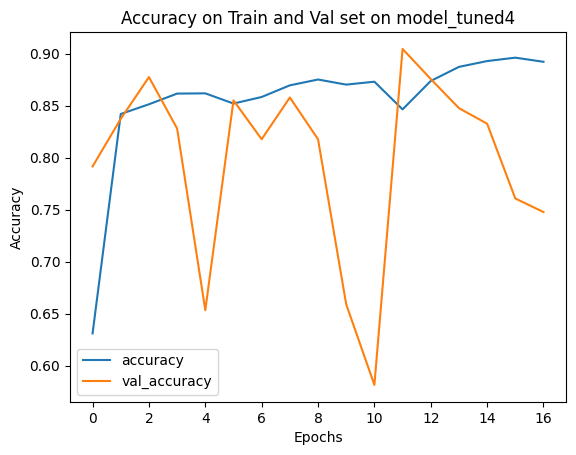

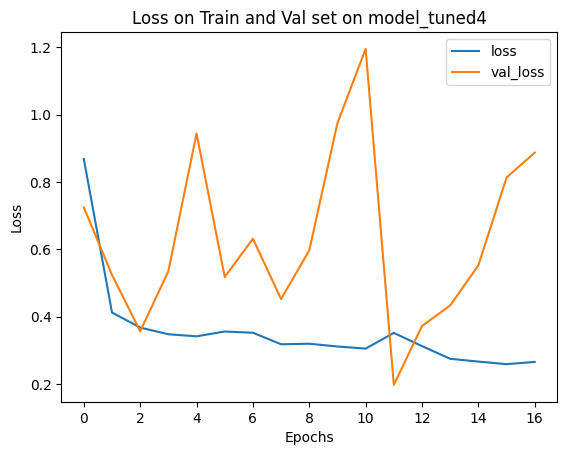

In [103]:
plot_model_history(history_model_tuned4, model_tuned4.name)

In [99]:
history_model_tuned3.iloc[-1]

accuracy        0.896495
loss            0.256573
val_accuracy    0.852336
val_loss        0.456973
Name: 19, dtype: float64

In [100]:
history_model_tuned4.iloc[-1]

accuracy        0.892290
loss            0.265453
val_accuracy    0.747664
val_loss        0.887327
Name: 16, dtype: float64

- Adding kernel initializer to the model's layers actually make the performance worse
- Validation loss of this model increased from 46% to 89%

### Evaluation

In [97]:
print_model_evaluation(model_tuned4, img_test_rgb_tuned2)

accuracy: 0.89

classification report
              precision    recall  f1-score   support

      cloudy       1.00      0.72      0.84        75
      desert       0.75      1.00      0.85        56
  green_area       0.87      1.00      0.93        75
       water       0.97      0.85      0.91        75

    accuracy                           0.89       281
   macro avg       0.90      0.89      0.88       281
weighted avg       0.91      0.89      0.88       281



Accuracy of this model on test data also worse from 93% to 89%

## Hyperparameter Tuning 5

add 2 dropout layers, 1 before flatten and 1 before output layer

In [101]:
model_tuned5 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Dropout(
        rate=0.2,
        seed=9
    ),    
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dropout(
        rate=0.5,
        seed=9
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model_tuned5")

model_tuned5.summary()

Model: "model_tuned5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 128)    │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 32, 32, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,689,988 (128.52 MB)

 Trainable params: 33,689,988 (128.52 MB)

 Non-trainable params: 0 (0.00 B)

In [102]:
%%time
history_model_tuned5 = get_model_history(
    model_tuned5,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    ["accuracy"],
    img_train_rgb_tuned2,
    img_val_rgb_tuned2,
    20,
    callbacks=[get_early_stopping()]
)

history_model_tuned5

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 35s 770ms/step - accuracy: 0.5234 - loss: 0.9701 - val_accuracy: 0.7794 - val_loss: 0.6794
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 608ms/step - accuracy: 0.7225 - loss: 0.5334 - val_accuracy: 0.8019 - val_loss: 0.6688
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 632ms/step - accuracy: 0.8065 - loss: 0.4457 - val_accuracy: 0.8215 - val_loss: 0.5735
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 594ms/step - accuracy: 0.8427 - loss: 0.3991 - val_accuracy: 0.8439 - val_loss: 0.4925
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 606ms/step - accuracy: 0.8548 - loss: 0.3646 - val_accuracy: 0.8738 - val_loss: 0.3986
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 603ms/step - accuracy: 0.8689 - loss: 0.3309 - val_accuracy: 0.8421 - val_loss: 0.5139
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 593ms/step - accuracy: 0.8669 - loss: 0.3277 - val_accuracy: 0.8850 - val_loss: 0.3245
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 607ms/step - accuracy: 0.8665 - loss: 0.3296 - val_accu

accuracy      loss  val_accuracy  val_loss
0   0.603037  0.769104      0.779439  0.679433
1   0.733411  0.523078      0.801869  0.668800
2   0.817991  0.429113      0.821495  0.573461
3   0.843692  0.392547      0.843925  0.492479
4   0.852804  0.367596      0.873832  0.398645
5   0.864019  0.340801      0.842056  0.513879
6   0.866121  0.330765      0.885047  0.324542
7   0.873832  0.322473      0.822430  0.579662
8   0.876168  0.309698      0.872897  0.370104
9   0.880374  0.296192      0.836449  0.477346
10  0.877336  0.295062      0.804673  0.621229
11  0.884346  0.280843      0.874766  0.383779
12  0.895327  0.264832      0.800935  0.577737
13  0.893692  0.261061      0.874766  0.363158
14  0.891355  0.264127      0.816822  0.606753
15  0.895093  0.263039      0.889720  0.331257
16  0.897196  0.257086      0.843925  0.482666
17  0.898832  0.251519      0.831776  0.543202
18  0.902336  0.242137      0.864486  0.407184
19  0.903271  0.248315      0.874766  0.396891

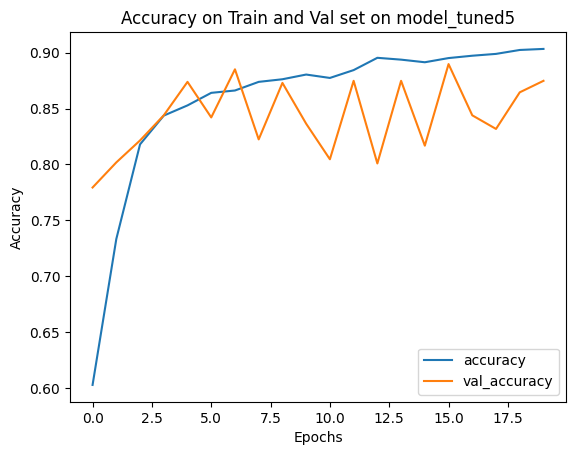

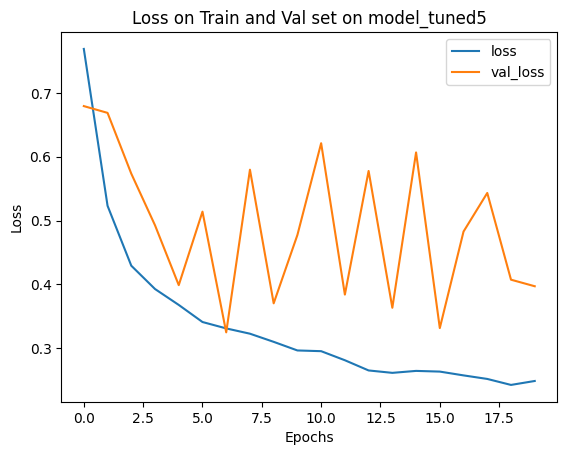

In [104]:
plot_model_history(history_model_tuned5, model_tuned5.name)

In [110]:
history_model_tuned4.iloc[-1]

accuracy        0.892290
loss            0.265453
val_accuracy    0.747664
val_loss        0.887327
Name: 16, dtype: float64

In [111]:
history_model_tuned5.iloc[-1]

accuracy        0.903271
loss            0.248315
val_accuracy    0.874766
val_loss        0.396891
Name: 19, dtype: float64

### Evaluation

In [105]:
print_model_evaluation(model_tuned5, img_test_rgb_tuned2)

accuracy: 0.95

classification report
              precision    recall  f1-score   support

      cloudy       0.99      0.92      0.95        75
      desert       0.93      0.98      0.96        56
  green_area       0.92      0.97      0.95        75
       water       0.95      0.92      0.93        75

    accuracy                           0.95       281
   macro avg       0.95      0.95      0.95       281
weighted avg       0.95      0.95      0.95       281



# Model Mislcassification Analysis

In [98]:
img_test_df["label"].value_counts()

label
cloudy        75
green_area    75
water         75
desert        56
Name: count, dtype: int64

In [119]:
pred_res = model_tuned2.predict(img_test_rgb_tuned2)
pred_res = np.argmax(pred_res, axis=1)
pred_res

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3])

In [120]:
# create a dataframe to contain true and pred label
img_test_analysis = pd.DataFrame()
img_test_analysis["true_label"] = img_test_rgb_tuned2.classes
img_test_analysis["pred_label"] = pred_res

In [121]:
img_test_analysis

true_label  pred_label
0             0           0
1             0           0
2             0           0
3             0           0
4             0           0
..          ...         ...
276           3           3
277           3           3
278           3           3
279           3           3
280           3           3

[281 rows x 2 columns]

In [126]:
# filter miss-classified images
miss_pred_df = img_test_analysis[
    img_test_analysis["true_label"]!=img_test_analysis["pred_label"]
]
miss_pred_df

true_label  pred_label
18            0           1
39            0           1
40            0           1
54            0           3
70            0           1
118           1           0
190           2           3
197           2           3
208           3           2
213           3           2
221           3           2
230           3           2
239           3           2
270           3           2
275           3           2

In [128]:
# filter image that miss-classifed as cloudy
miss_classified_as_cloudy = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==0].index]
miss_classified_as_cloudy

label                                      path
2076  desert  /kaggle/input/data/desert/desert(87).jpg

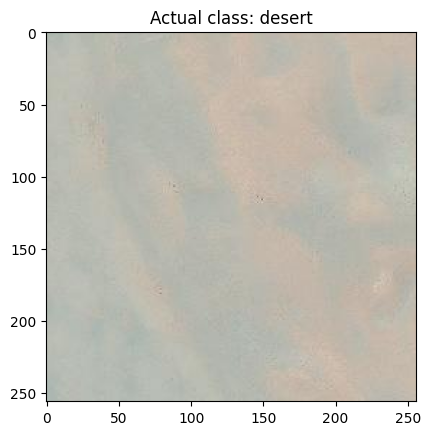

In [141]:
# plot image that miss-classifed as cloudy
for _, v in miss_classified_as_cloudy.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- Turns out that this dessert image actually has similar color characteristic with cloudy.

In [146]:
# filter image that miss-classifed as desert
miss_classified_as_desert = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==1].index]
miss_classified_as_desert

label                                       path
775   cloudy  /kaggle/input/data/cloudy/train_40320.jpg
846   cloudy   /kaggle/input/data/cloudy/train_7323.jpg
1381  cloudy   /kaggle/input/data/cloudy/train_1500.jpg
1111  cloudy  /kaggle/input/data/cloudy/train_28686.jpg

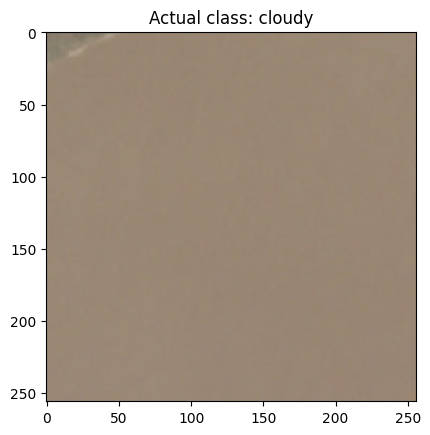

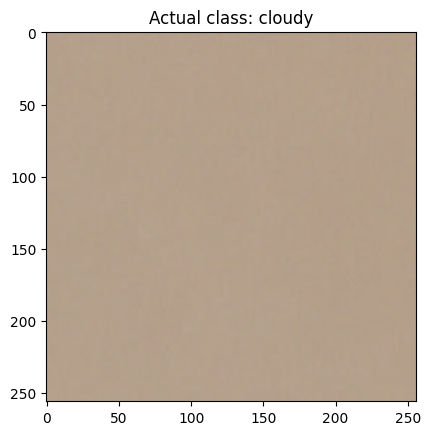

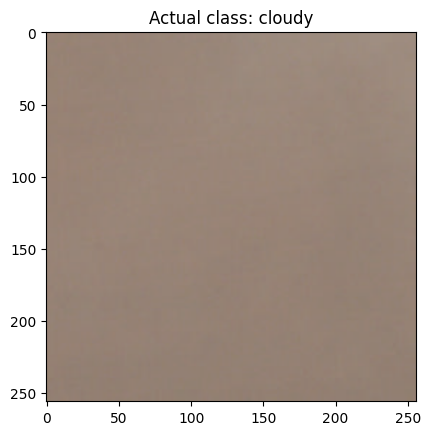

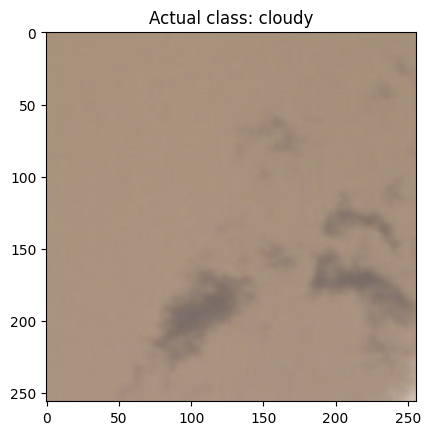

In [147]:
# plot image that miss-classifed as desert
for _, v in miss_classified_as_desert.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- All images that the model misclassified as desert are similar to actual desert images
- These images are all having brownish color

- This conclude that some cloudy and desert images in the dataset are having similar colors.
- It might be that there's not enough cloudy image that similar to desert and vice versa in the dataset, so the model is uncorrectly identify these images' characteristics

In [148]:
# filter image that miss-classifed as green area
miss_classified_as_green_area = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==2].index]
miss_classified_as_green_area

label                                       path
5123  water  /kaggle/input/data/water/SeaLake_2738.jpg
5552  water   /kaggle/input/data/water/SeaLake_741.jpg
5243  water   /kaggle/input/data/water/SeaLake_905.jpg
4564  water   /kaggle/input/data/water/SeaLake_785.jpg
4525  water  /kaggle/input/data/water/SeaLake_2624.jpg
5610  water  /kaggle/input/data/water/SeaLake_1507.jpg
4291  water   /kaggle/input/data/water/SeaLake_942.jpg

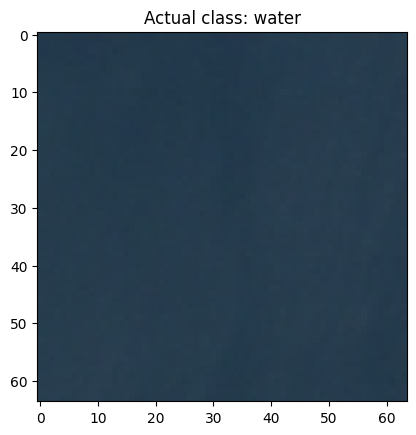

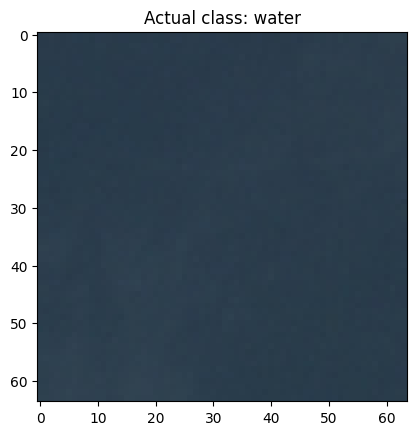

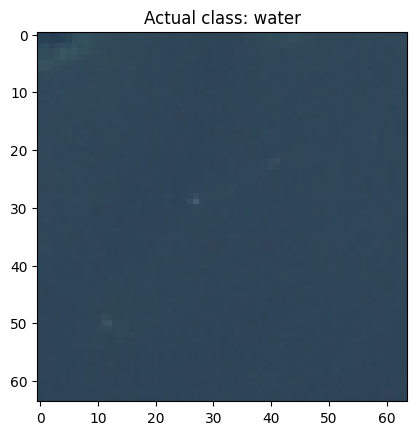

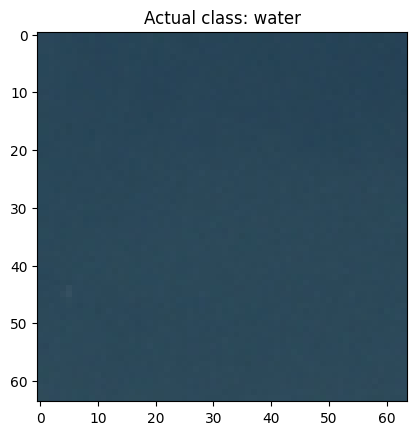

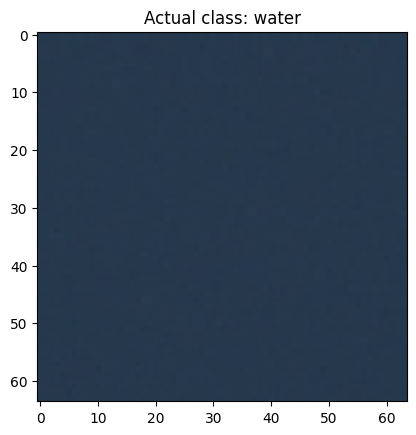

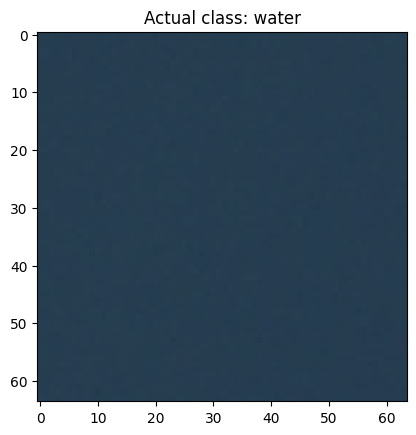

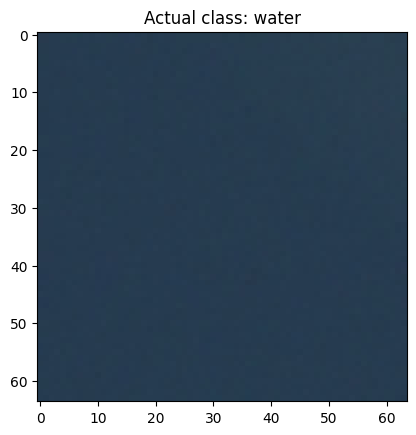

In [149]:
# plot image that miss-classifed as green area
for _, v in miss_classified_as_green_area.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- All images that the model misclassified as green area are having mixed green and blue colors

In [150]:
# filter image that miss-classifed as water
miss_classified_as_water = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==3].index]
miss_classified_as_water

label                                           path
957       cloudy      /kaggle/input/data/cloudy/train_16325.jpg
3140  green_area  /kaggle/input/data/green_area/Forest_2154.jpg
3143  green_area  /kaggle/input/data/green_area/Forest_2113.jpg

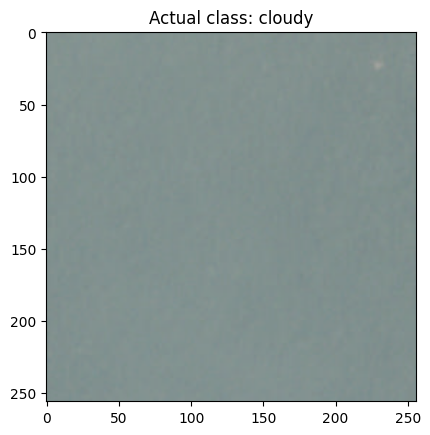

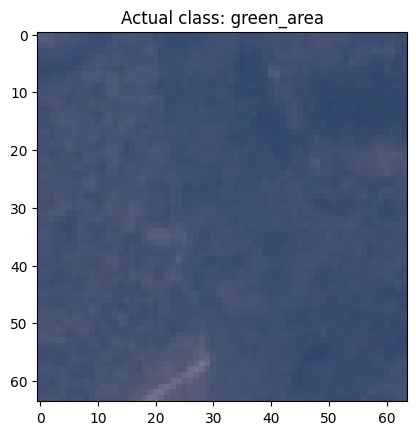

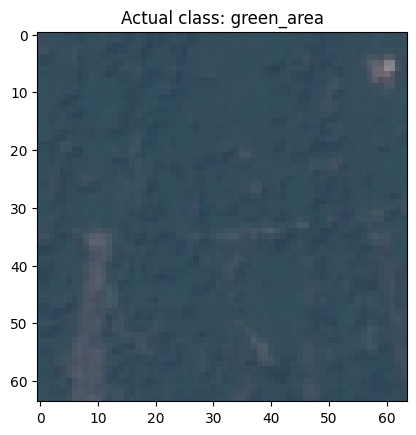

In [151]:
# plot image that miss-classifed as water
for _, v in miss_classified_as_water.iterrows():
    plt.imshow(
        read_img_rgb(v["path"])
    )
    plt.title("Actual class: {}".format(v["label"]))
    plt.show()

- All images that the model misclassified as water are having mixed green and blue colors, except the first one

- This conclude that, some green area and water images in the dataset are having mixed green and blue color.
- This misclassification also occurred because there are not enough water images similar to green areas, and vice versa, in the dataset

# Conclusion

- Tuned model is the best model to be used in NASA's system since it produced 90% accuracy and meets the minimum accuracy requirement stated in objective
- 90% accuracy means that `out of 10 images for every classes(cloudy, green area, desert, and water), this model able to correctly classify 9 of them`

Further improvement:
- Despite this model able to meet the minimum requirement on accuracy score, the model's size is exceptionally. As stated in [this reference](https://www.linkedin.com/pulse/your-model-slow-vijay-raghavan-ph-d-m-b-a-/), larger model tends to inference slower.

- The model can be improved by decreasing the number of units in the dense layers and the filter size in the convolution layers respectively, this will make the model's size to decrease. But the model's accuracy on the training, validation, and test data must remain similar, if not the same.

- The model also has some pattern in terms of misclassifying images, such as:
    - some water images misclassified as green area, and vice versa
    - some cloudy images misclassified as desert, and vice versa
- To encounter this problem, the dataset must be improved by:
    - providing water images that similar to green area, and vice versa.
    - providing cloudy images that similar to desert, and vice versa.